# Combined method which generates trajectories by:
Generate N trajectories with following steps:
- Choose which model to apply (const vel or const vel with angle)
  - choose base velocity and angle either from average velocity or discounted average velocity
- At each predict timestep randomly apply:
  - velocity change
  - angle change
  - randomly stopping

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
import scipy.stats as st
#np.random.seed(42)

In [2]:
# Edinburgh
from data_processing import read_edinburgh_data 
data, agent_ids = read_edinburgh_data()

/Users/kriis/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


reading:./OpenTraj/datasets/Edinburgh/annotations/tracks.01Sep.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2342/2342 [01:03<00:00, 36.86it/s]


Warning! too big dt in [Edinburgh]
finish


### Helper methods

In [3]:
def agent_data(data, agent_id):
    x = data["pos_x"].loc[data["agent_id"]==agent_id].values
    y = data["pos_y"].loc[data["agent_id"]==agent_id].values

    max_train_idx = len(x)-10
    
    return x, y, max_train_idx

# Sample train and test data for pos_x and pos_y, each slice with num_steps length
def generate_data(data, begin_idx, agent_id, num_steps=5):
    sample_x = data["pos_x"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values
    sample_y = data["pos_y"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values

    test_x = data["pos_x"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    test_y = data["pos_y"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    
    return sample_x, sample_y, test_x, test_y
    
def calculate_FDE(pred_x, pred_y, test_x, test_y):

    final_displacement_x = pred_x[-1] - test_x[-1]
    final_displacement_y = pred_y[-1] - test_y[-1]
    FDE = np.sqrt(final_displacement_x**2 + final_displacement_y**2)
    
    return FDE

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

In [27]:
def kernel_density_estimation(x_data, y_data, start_idx, sample_x, sample_y, test_x, test_y, all_final_x, all_final_y):
    all_final_x = np.array(all_final_x)
    all_final_y = np.array(all_final_y)
    
    xmin, xmax = min(all_final_x), max(all_final_x)
    ymin, ymax = min(all_final_y), max(all_final_y)
    
    xdiff = xmax - xmin
    ydiff = ymax - ymin
    
    xmin = xmin - xdiff
    xmax = xmax + xdiff
    
    ymin = ymin - ydiff
    ymax = ymax + ydiff
    
    # Peform the kernel density estimate
    xx, yy = np.mgrid[xmin:xmax:300j, ymin:ymax:300j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([all_final_x, all_final_y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    plot_KDE(sample_x, sample_y, test_x, test_y, xx, yy, f)
    plot_KDE_w_whole_trajectory(x_data, y_data, start_idx, xx, yy, f)

### Plotting

In [33]:
def plot_KDE(sample_x, sample_y, test_x, test_y, xx, yy, f):
    plt.figure(figsize=(10, 10))
    plt.axes().set_aspect('equal')
    
    CS = plt.contour(xx, yy, f, levels=[0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56])
    plt.clabel(CS, inline=1, fontsize=10)
    
    plt.plot(sample_x, sample_y, c='green')
    plt.scatter(sample_x, sample_y, c='green')
    
    plt.scatter(sample_x[0], sample_y[0], c='blue', linewidth=3)
    
    plt.scatter(test_x, test_y, c='orange')
    plt.plot(np.append(sample_x[-1], test_x), np.append(sample_y[-1],test_y), '--', c='orange')
    plt.show()
    
def plot_KDE_w_whole_trajectory(x_data, y_data, start_idx, xx, yy, f):
    plt.figure(figsize=(10, 10))
    plt.axes().set_aspect('equal')
    
    CS = plt.contour(xx, yy, f, levels=[0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56])
    plt.clabel(CS, inline=1, fontsize=10)
    
    plt.plot(x_data, y_data, c='green')
    plt.scatter(x_data, y_data, c='green')
    
    plt.scatter(x_data[0], y_data[0], c='blue', linewidth=3)
    
    plt.plot(x_data[start_idx:start_idx+5], y_data[start_idx:start_idx+5], c='yellow')
    plt.scatter(x_data[start_idx:start_idx+5], y_data[start_idx:start_idx+5], c='yellow')
    
    plt.plot(x_data[start_idx+5:start_idx+10], y_data[start_idx+5:start_idx+10], c='orange')
    plt.scatter(x_data[start_idx+5:start_idx+10], y_data[start_idx+5:start_idx+10], c='orange')
    plt.show()
    
def plot_all_trajectories(x_data, y_data, pred_xs, pred_ys, start_idx):
    plt.figure(figsize=(10, 10))
    plt.axes().set_aspect('equal')
    
    plt.plot(x_data, y_data, c='green')
    plt.scatter(x_data, y_data, c='green')
    
    plt.scatter(x_data[0], y_data[0], c='blue', linewidth=3)
    
    plt.plot(x_data[start_idx:start_idx+5], y_data[start_idx:start_idx+5], c='yellow')
    plt.scatter(x_data[start_idx:start_idx+5], y_data[start_idx:start_idx+5], c='yellow')
    
    plt.plot(x_data[start_idx+5:start_idx+10], y_data[start_idx+5:start_idx+10], c='orange')
    plt.scatter(x_data[start_idx+5:start_idx+10], y_data[start_idx+5:start_idx+10], c='orange')
    
    for i in range(len(pred_xs)):
        plt.plot(pred_xs[i], pred_ys[i], linewidth=0.25)
    
    plt.show()

### Model

In [34]:
def get_model(params):
    if np.random.rand() < params['CONST_VEL_MODEL_PROB']:
        return 'CONST_VEL'
    else:
        return 'CONST_VEL_W_ROTATION'
    
def get_action(params):
    if np.random.rand() < params['STOP_PROB']:
        return 'STOP'
    if np.random.rand() < params['VELOCITY_CHANGE_PROB']:
        return 'VELOCITY_CHANGE'
    if np.random.rand() < params['ANGLE_CHANGE_PROB']:
        return 'ANGLE_CHANGE'
    return None

# Decide whether to use average or discounted average as const velocity
def get_const_vel(params, sample_vel_x, sample_vel_y):
    if np.random.rand() < params['DISCOUNT_AVG_PROB']:
        const_vel_x = (0.8**3*sample_vel_x[0] + 0.8**2*sample_vel_x[1] + 0.8*sample_vel_x[2] + sample_vel_x[3]) / (0.8**3 + 0.8**2 + 0.8 + 1)
        const_vel_y = (0.8**3*sample_vel_y[0] + 0.8**2*sample_vel_y[1] + 0.8*sample_vel_y[2] + sample_vel_y[3]) / (0.8**3 + 0.8**2 + 0.8 + 1)
    else:
        const_vel_x = np.mean(sample_vel_x)
        const_vel_y = np.mean(sample_vel_y)
        
    return const_vel_x, const_vel_y

# Decide whether to use average or discounted average angle
def get_angle(sample_vel_x, sample_vel_y):
    all_angles = []
    for i in range(1, len(sample_vel_x)):
        prev_vel = [sample_vel_x[i-1], sample_vel_y[i-1]]
        curr_vel = [sample_vel_x[i], sample_vel_y[i]]
        one_angle = np.math.atan2(np.linalg.det([prev_vel, curr_vel]),np.dot(prev_vel, curr_vel))   
        all_angles.append(one_angle)
    
    if np.random.rand() < params['DISCOUNT_AVG_PROB']:
        angle = (0.8**2*all_angles[0] + 0.8**1*all_angles[1] + all_angles[2]) / (0.8**2 + 0.8 + 1)
    else:
        angle = np.mean(all_angles)
    return angle

def predict(sample_x, sample_y, agent_id, start_idx, params):
    # calculate velocity data
    sample_vel_x = [(sample_x[i] - sample_x[i-1]) + np.random.normal(0, params['NOISE']) for i in range(1, len(sample_x))]
    sample_vel_y = [(sample_y[i] - sample_y[i-1]) + np.random.normal(0, params['NOISE']) for i in range(1, len(sample_y))]
    
    const_vel_x, const_vel_y = get_const_vel(params, sample_vel_x, sample_vel_y)
    angle = get_angle(sample_vel_x, sample_vel_y)
    
    # start predicting
    pred_x = []
    pred_y = []
    model = get_model(params)
    for i in range(5):
        action = get_action(params)
        if action == 'STOP':
            if len(pred_x) == 0:
                pred_x.append(sample_x[-1])
                pred_y.append(sample_y[-1])
            else:
                pred_x.append(pred_x[-1])
                pred_y.append(pred_y[-1])
            continue
            
        elif action == 'VELOCITY_CHANGE':
            const_vel_x = const_vel_x + np.random.normal(0, params['VELOCITY_CHANGE_NOISE'])
            const_vel_y = const_vel_y + np.random.normal(0, params['VELOCITY_CHANGE_NOISE'])
        elif action == 'ANGLE_CHANGE':
            angle = angle + np.random.normal(0, params['ANGLE_CHANGE_NOISE'])
        
        if model == 'CONST_VEL':
            if len(pred_x) == 0:
                pred_x.append(sample_x[-1] + const_vel_x)
                pred_y.append(sample_y[-1] + const_vel_y)
            else:
                pred_x.append(pred_x[-1] + const_vel_x)
                pred_y.append(pred_y[-1] + const_vel_y)
        elif model == 'CONST_VEL_W_ROTATION':
            if len(pred_x) == 0:
                prev_x = sample_x[-2]
                prev_y = sample_y[-2]
                cur_x = sample_x[-1] + const_vel_x
                cur_y = sample_y[-1] + const_vel_y
            else:
                prev_x = pred_x[-1]
                prev_y = pred_y[-1]
                cur_x = pred_x[-1] + const_vel_x
                cur_y = pred_y[-1] + const_vel_y
            rot_x, rot_y = rotate((prev_x, prev_y), (cur_x, cur_y), angle)
            pred_x.append(rot_x)
            pred_y.append(rot_y)
            
            # redefine the average velocity as it now has a new heading
            const_vel_x = rot_x - prev_x
            const_vel_y = rot_y - prev_y
        
    return pred_x, pred_y
            

### Running the experiment

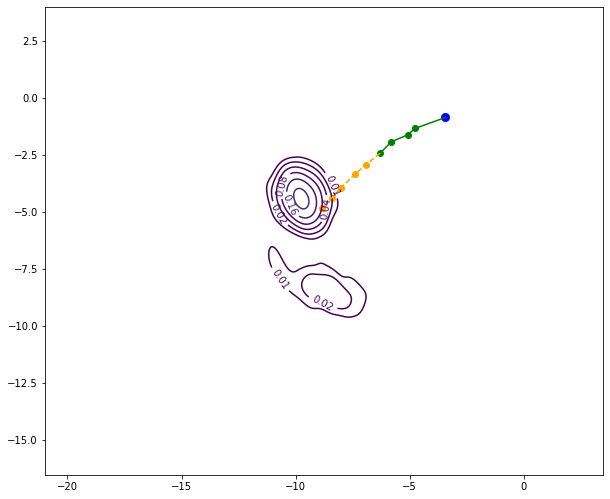

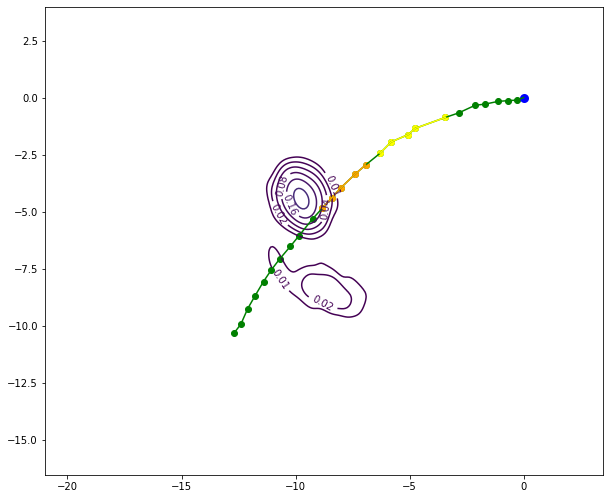

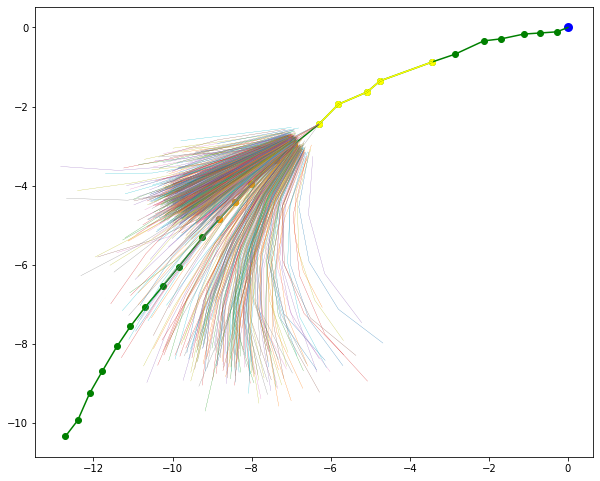

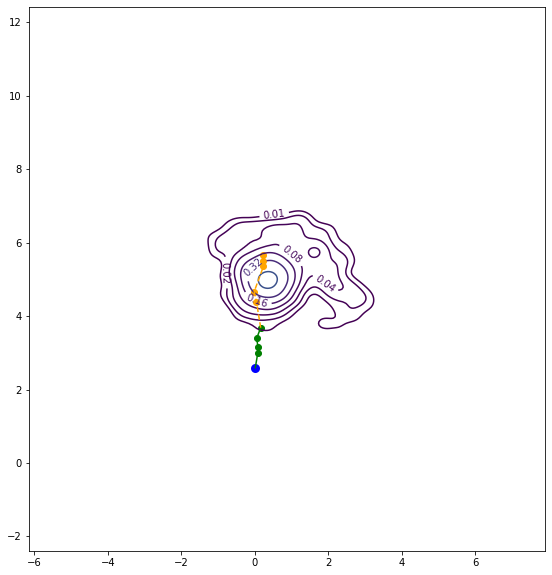

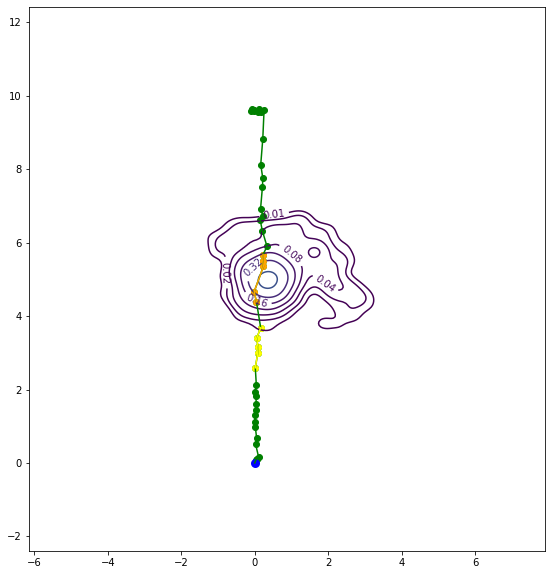

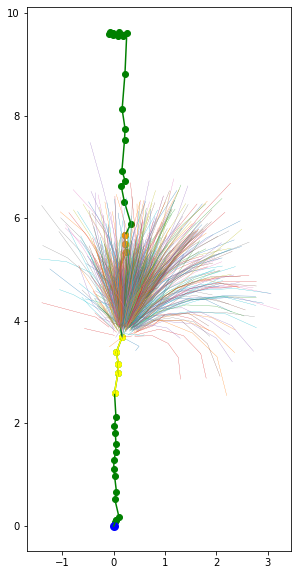

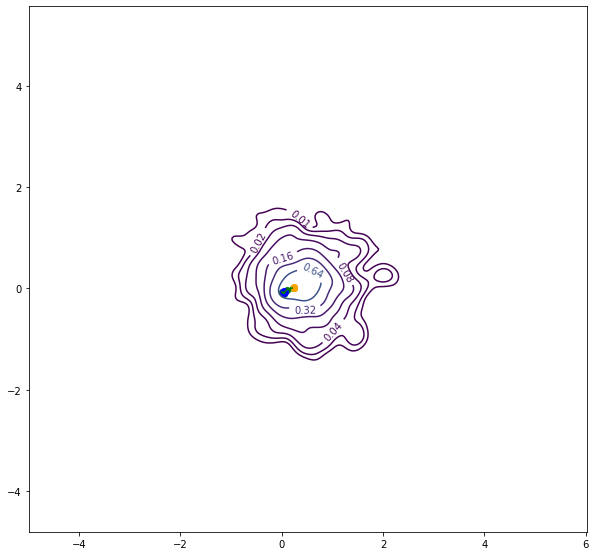

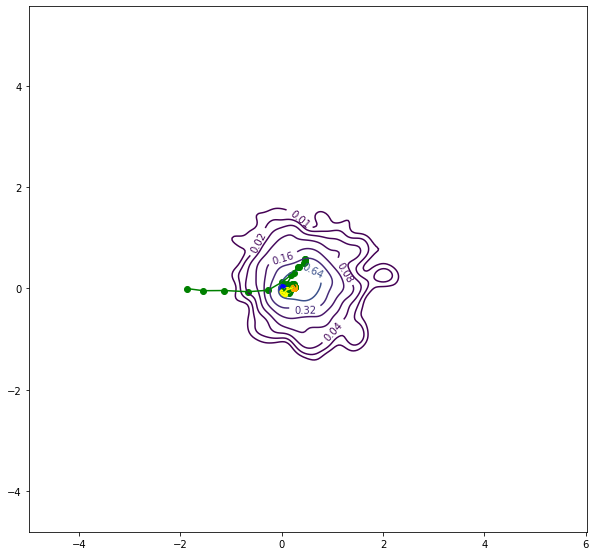

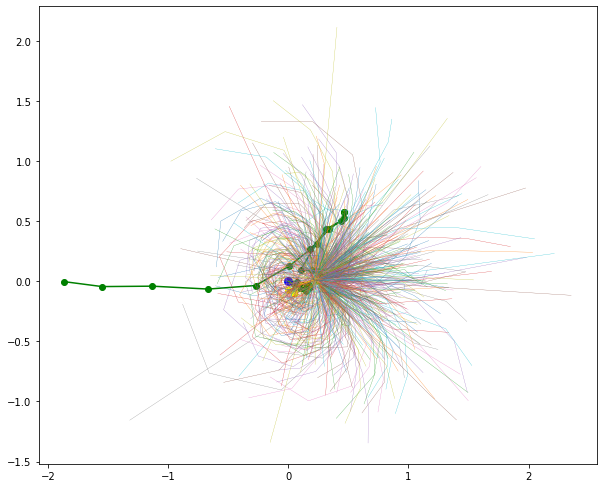

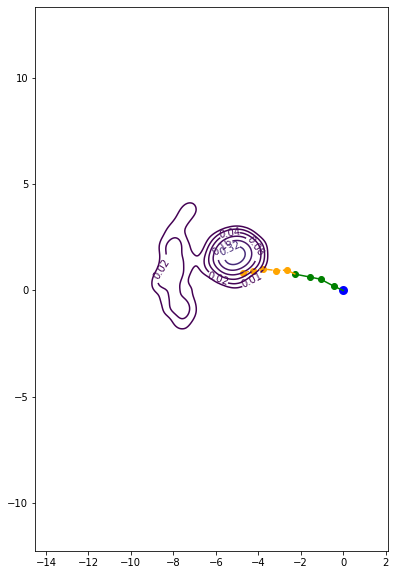

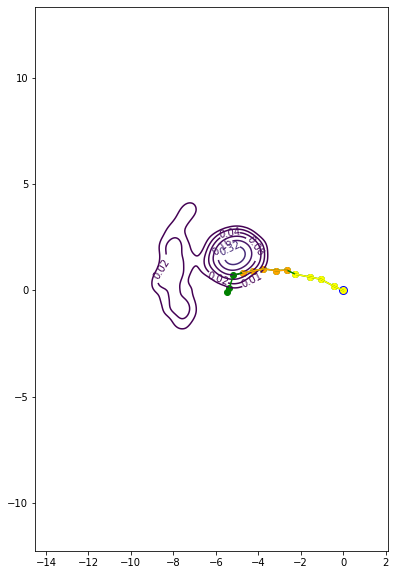

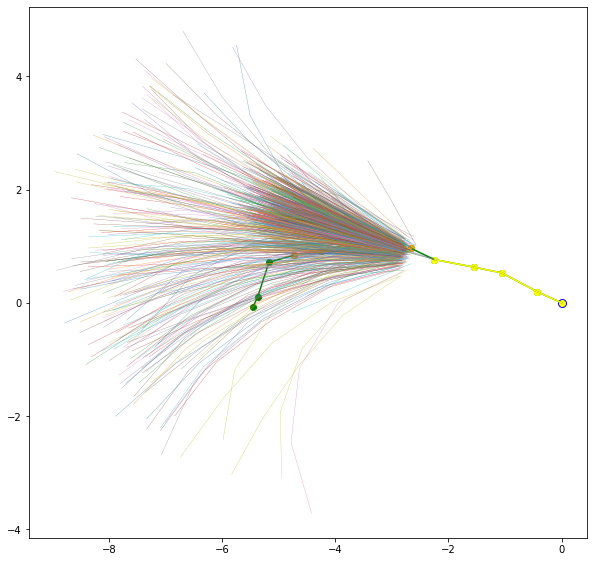

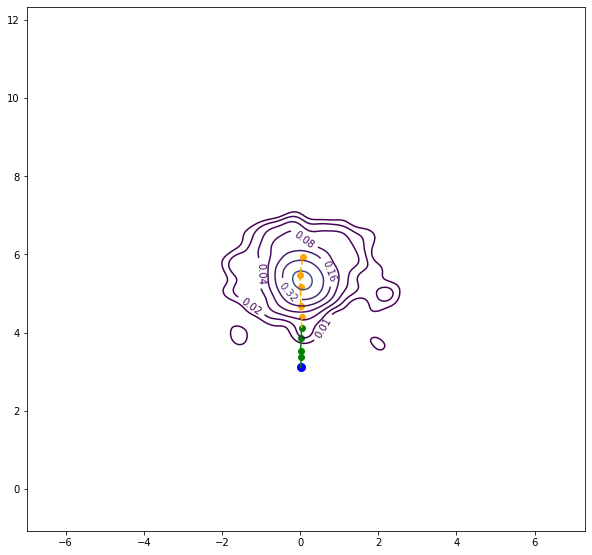

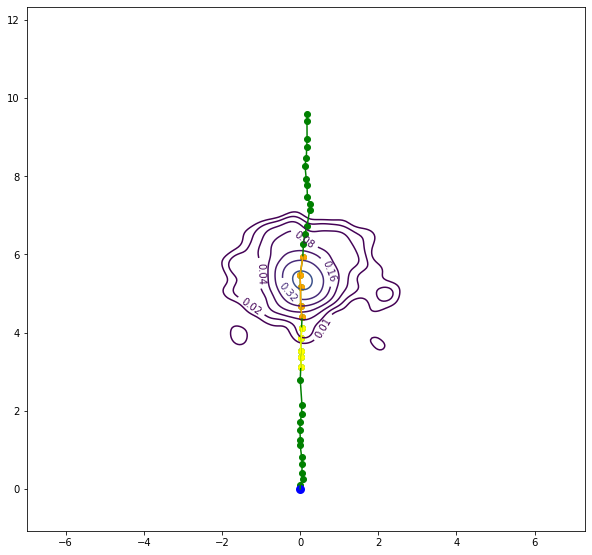

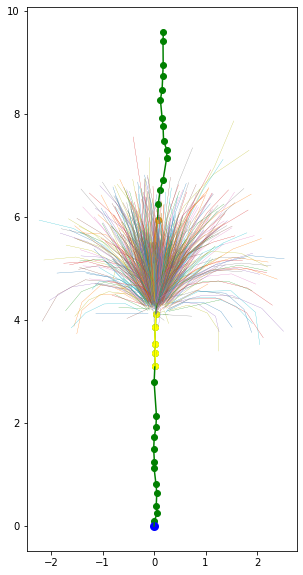

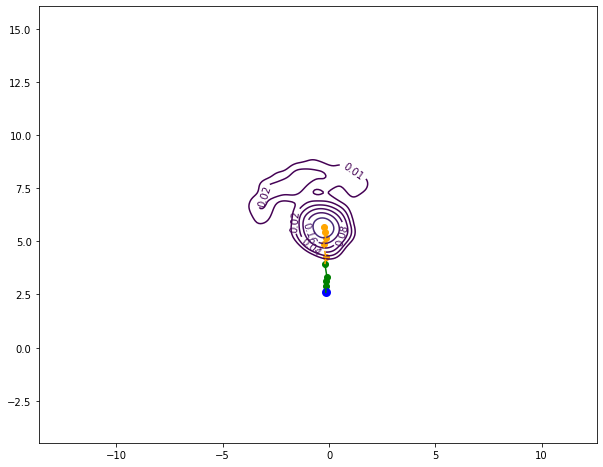

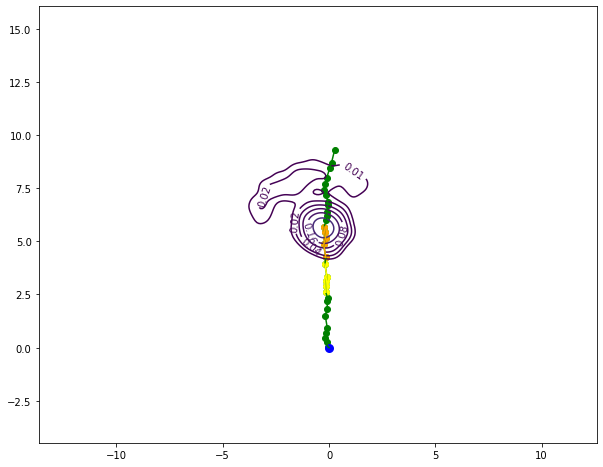

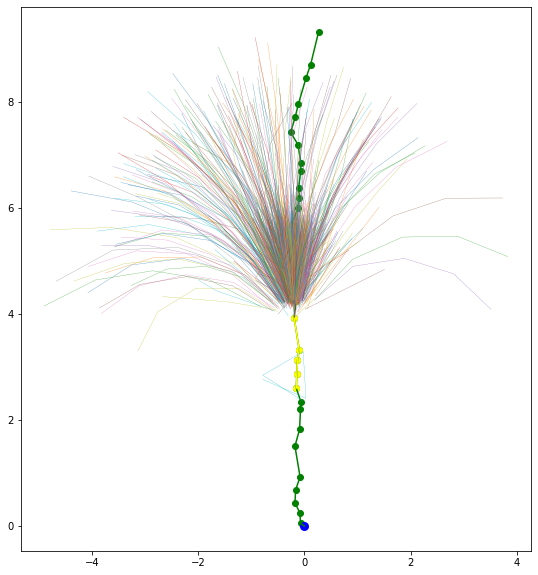

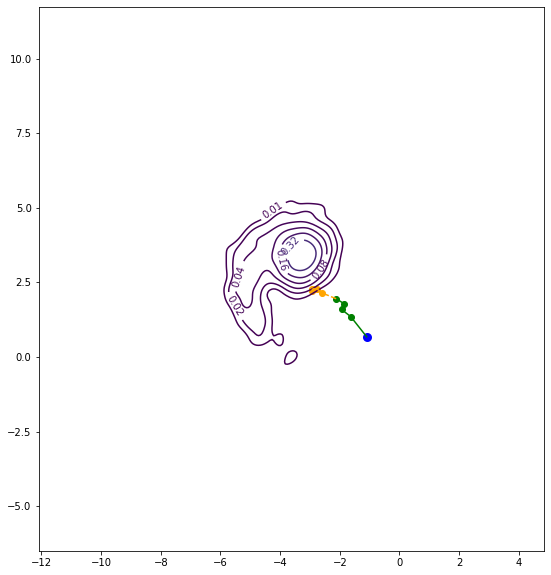

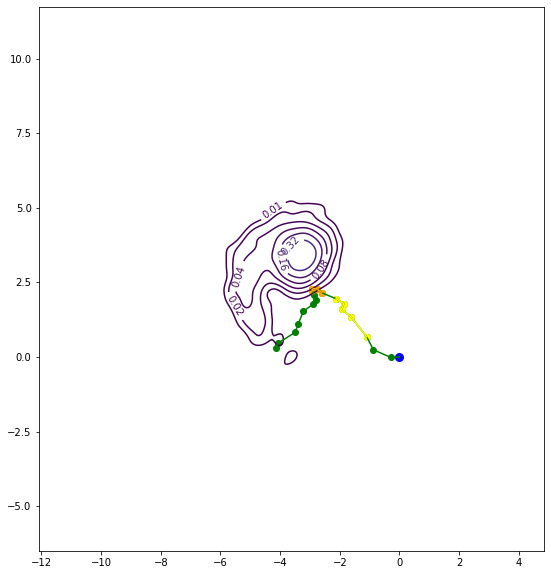

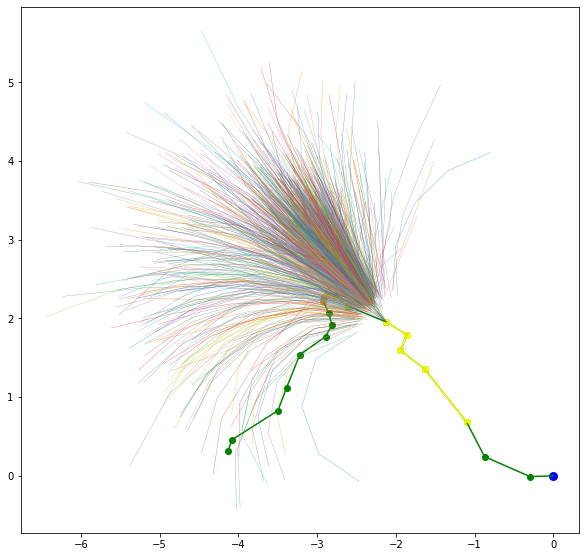

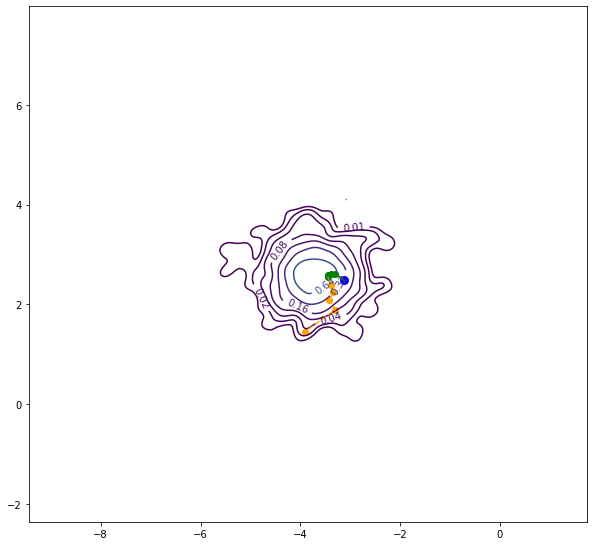

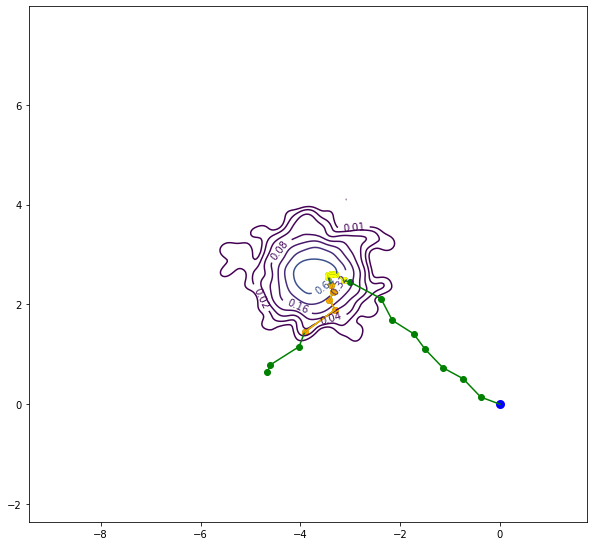

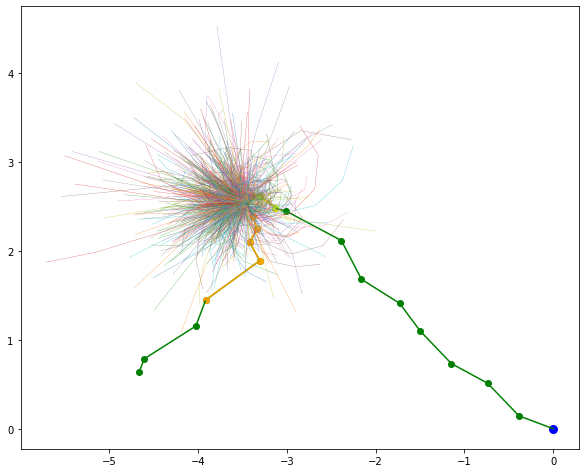

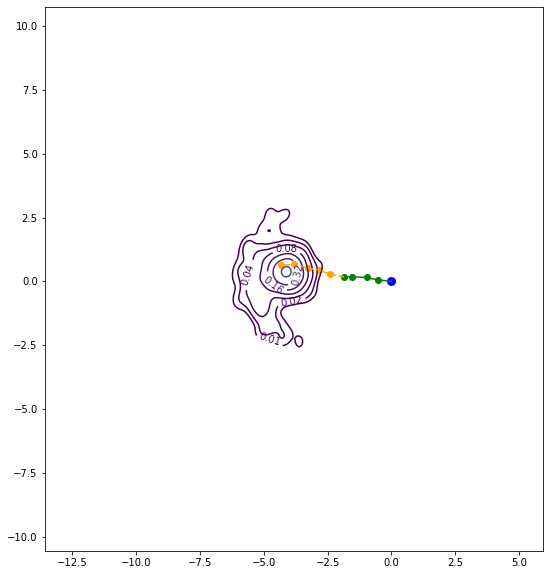

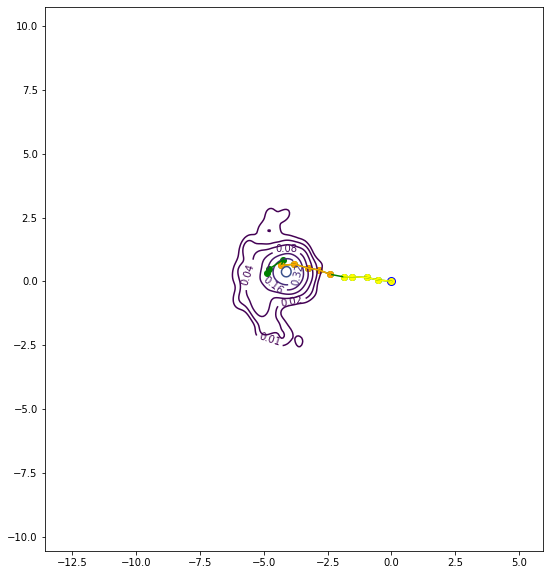

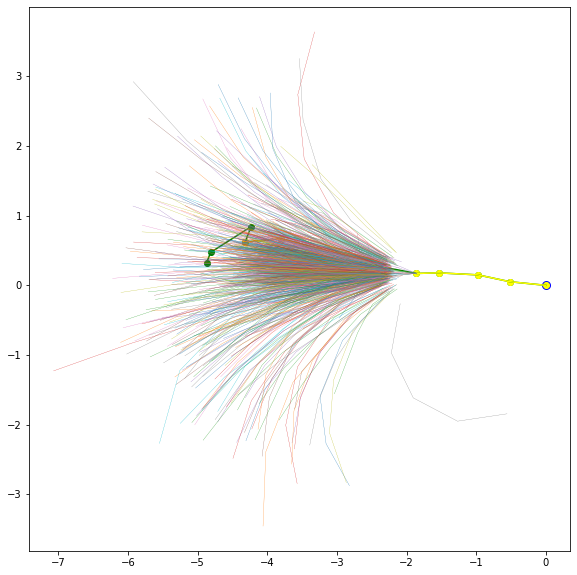

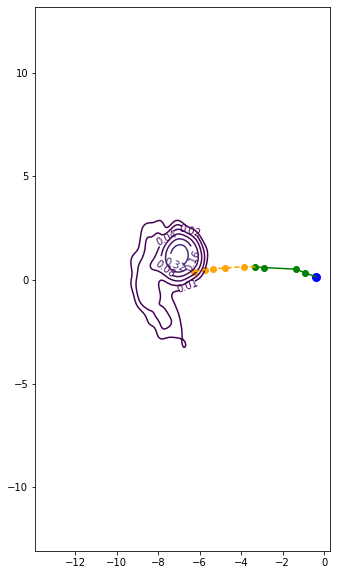

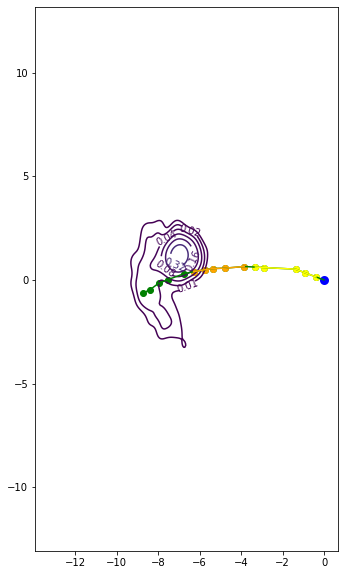

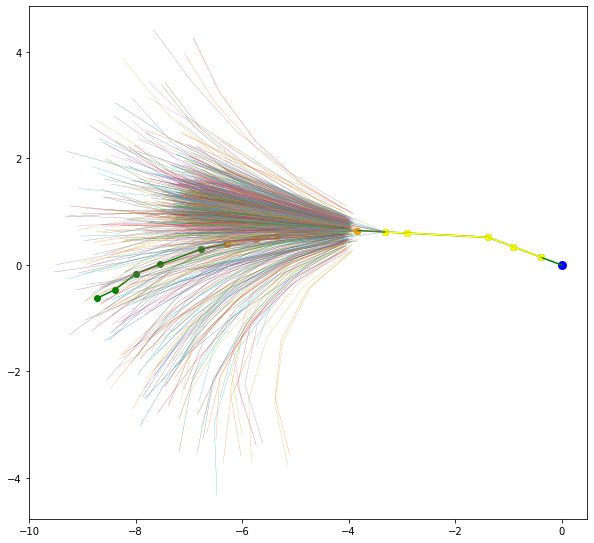

In [35]:
params = {
    "NOISE": 0.1,
    "NO_OF_TRAJECTORIES": 1000,
    "CONST_VEL_MODEL_PROB": 0.8,
    
    "STOP_PROB": 0.01,
    "DISCOUNT_AVG_PROB": 0.5,
    
    "VELOCITY_CHANGE_PROB": 0.2,
    "VELOCITY_CHANGE_NOISE": 0.1,
    
    "ANGLE_CHANGE_PROB": 0.2,
    "ANGLE_CHANGE_NOISE": 0.1
}

for agent_id in agent_ids[:10]:
    x_data, y_data, max_train_idx = agent_data(data, agent_id)
    start_idx = np.random.randint(0, max_train_idx)
    sample_x, sample_y, test_x, test_y = generate_data(data, start_idx, agent_id, 5)
    
    all_pred_x, all_pred_y = [], []
    all_final_x, all_final_y = [], []
    for i in range(params['NO_OF_TRAJECTORIES']):
        pred_x, pred_y = predict(sample_x, sample_y, agent_id, start_idx, params)
        #print(pred_x)
        all_pred_x.append(pred_x)
        all_pred_y.append(pred_y)
        
        all_final_x.append(pred_x[-1])
        all_final_y.append(pred_y[-1])
        
    kernel_density_estimation(x_data, y_data, start_idx, sample_x, sample_y, test_x, test_y, all_final_x, all_final_y)
    plot_all_trajectories(x_data, y_data, all_pred_x, all_pred_y, start_idx)
    print("======================================================")